In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install pytorch-crf

In [2]:
import os
import json
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn import init
import torch.nn.functional as F
import argparse
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.nn import TransformerEncoder, TransformerEncoderLayer
# from torchcrf import CRF
import math

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip
# !mv glove.6B.100d.txt ./drive/MyDrive/nlp/textmining_CW/embedding/

In [3]:
class Config(object):
    def __init__(self):
        # get init config
        args = self.__get_config()
        for key in args.__dict__:
            setattr(self, key, args.__dict__[key])

        # select device
        self.device = None
        if self.cuda >= 0 and torch.cuda.is_available():
            self.device = torch.device('cuda:{}'.format(self.cuda))
        else:
            self.device = torch.device('cpu')

        # determine the model name and model dir
        if self.model_name is None:
            self.model_name = 'Att_LSTM'
        self.model_dir = os.path.join(self.output_dir, self.model_name)
        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)

        # backup data
        self.__config_backup(args)

        # set the random seed
        self.__set_seed(self.seed)

    def __get_config(self):
        parser = argparse.ArgumentParser()
        parser.description = 'config for models'

        # several key selective parameters
        parser.add_argument('--data_dir', type=str,
                            default='./drive/MyDrive/nlp/textmining_CW/data',
                            help='dir to load data')
        parser.add_argument('--output_dir', type=str,
                            default='./drive/MyDrive/nlp/textmining_CW/output',
                            help='dir to save output')

        # word embedding
        parser.add_argument('--embedding_path', type=str,
                            default='./drive/MyDrive/nlp/textmining_CW/embedding/glove.6B.100d.txt',
                            help='pre_trained word embedding')
        parser.add_argument('--word_dim', type=int,
                            default=100,
                            help='dimension of word embedding')

        # train settings
        parser.add_argument('--model_name', type=str,
                            default=None,
                            help='model name')
        parser.add_argument('--mode', type=int,
                            default=1,
                            choices=[0, 1],
                            help='running mode: 1 for training; otherwise testing')
        parser.add_argument('--seed', type=int,
                            default=20250215,
                            help='random seed')
        parser.add_argument('--cuda', type=int,
                            default=0,
                            help='num of gpu device, if -1, select cpu')
        parser.add_argument('--epoch', type=int,
                            default=10,
                            help='max epoches during training') # 原本是30 ，感觉太大了

        # hyper parameters
        parser.add_argument('--batch_size', type=int,
                            default=10,
                            help='batch size')
        parser.add_argument('--lr', type=float,
                            default=1,
                            help='learning rate')
        parser.add_argument('--max_len', type=int,
                            default=100,
                            help='max length of sentence')

        parser.add_argument('--emb_dropout', type=float,
                            default=0.3,
                            help='the possiblity of dropout in embedding layer')
        parser.add_argument('--lstm_dropout', type=float,
                            default=0.3,
                            help='the possiblity of dropout in (Bi)LSTM layer')
        parser.add_argument('--linear_dropout', type=float,
                            default=0.5,
                            help='the possiblity of dropout in liner layer')
        parser.add_argument('--hidden_size', type=int,
                            default=100,
                            help='the dimension of hidden units in (Bi)LSTM layer')
        parser.add_argument('--layers_num', type=int,
                            default=1,
                            help='num of RNN layers')

        parser.add_argument('--L2_decay', type=float, default=1e-5,
                            help='L2 weight decay')

        args = parser.parse_args(args=[])
        return args

    def __set_seed(self, seed=1234):
        os.environ['PYTHONHASHSEED'] = '{}'.format(seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)  # set seed for cpu
        torch.cuda.manual_seed(seed)  # set seed for current gpu
        torch.cuda.manual_seed_all(seed)  # set seed for all gpu

    def __config_backup(self, args):
        config_backup_path = os.path.join(self.model_dir, 'config.json')
        with open(config_backup_path, 'w', encoding='utf-8') as fw:
            json.dump(vars(args), fw, ensure_ascii=False)

    def print_config(self):
        for key in self.__dict__:
            print(key, end=' = ')
            print(self.__dict__[key])

In [4]:
class Att_LSTM(nn.Module):
    def __init__(self, word_vec, class_num, config):
        super().__init__()
        self.word_vec = word_vec
        self.class_num = class_num

        # hyper parameters and others
        self.max_len = config.max_len
        self.word_dim = config.word_dim
        self.hidden_size = config.hidden_size
        self.layers_num = config.layers_num
        self.emb_dropout_value = config.emb_dropout
        self.lstm_dropout_value = config.lstm_dropout
        self.linear_dropout_value = config.linear_dropout

        # net structures and operations
        self.word_embedding = nn.Embedding.from_pretrained(
            embeddings=self.word_vec,
            freeze=False,
        )
        self.lstm = nn.LSTM(
            input_size=self.word_dim,
            hidden_size=self.hidden_size,
            num_layers=self.layers_num,
            bias=True,
            batch_first=True,
            dropout=0,
            bidirectional=False,  # 修改为单向 LSTM
        )
        self.tanh = nn.Tanh()
        self.emb_dropout = nn.Dropout(self.emb_dropout_value)
        self.lstm_dropout = nn.Dropout(self.lstm_dropout_value)
        self.linear_dropout = nn.Dropout(self.linear_dropout_value)

        self.att_weight = nn.Parameter(torch.randn(1, self.hidden_size, 1))
        self.dense = nn.Linear(
            in_features=self.hidden_size,
            out_features=self.class_num,
            bias=True
        )

        # initialize weight
        init.xavier_normal_(self.dense.weight)
        init.constant_(self.dense.bias, 0.)

    def lstm_layer(self, x, mask):
        lengths = torch.sum(mask.gt(0), dim=-1)
        lengths = lengths.cpu().type(torch.int64)
        x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        h, (_, _) = self.lstm(x)
        h, _ = pad_packed_sequence(h, batch_first=True, padding_value=0.0, total_length=self.max_len)
        # 由于是单向 LSTM，不需要求和
        return h

    def attention_layer(self, h, mask):
        att_weight = self.att_weight.expand(mask.shape[0], -1, -1)  # B*H*1
        att_score = torch.bmm(self.tanh(h), att_weight)  # B*L*H  *  B*H*1 -> B*L*1

        # mask, remove the effect of 'PAD'
        mask = mask.unsqueeze(dim=-1)  # B*L*1
        att_score = att_score.masked_fill(mask.eq(0), float('-inf'))  # B*L*1
        att_weight = F.softmax(att_score, dim=1)  # B*L*1

        reps = torch.bmm(h.transpose(1, 2), att_weight).squeeze(dim=-1)  # B*H*L *  B*L*1 -> B*H*1 -> B*H
        reps = self.tanh(reps)  # B*H
        return reps

    def forward(self, data):
        token = data[:, 0, :].view(-1, self.max_len)
        mask = data[:, 1, :].view(-1, self.max_len)
        emb = self.word_embedding(token)  # B*L*word_dim
        emb = self.emb_dropout(emb)
        h = self.lstm_layer(emb, mask)  # B*L*H
        h = self.lstm_dropout(h)
        reps = self.attention_layer(h, mask)  # B*reps
        reps = self.linear_dropout(reps)
        logits = self.dense(reps)
        return logits

In [5]:
class WordEmbeddingLoader(object):
    """
    A loader for pre-trained word embedding
    """

    def __init__(self, config):
        self.path_word = config.embedding_path  # path of pre-trained word embedding
        self.word_dim = config.word_dim  # dimension of word embedding

    def load_embedding(self):
        word2id = dict()  # word to wordID
        word_vec = list()  # wordID to word embedding

        word2id['PAD'] = len(word2id)  # PAD character
        word2id['UNK'] = len(word2id)  # out of vocabulary
        word2id['<e1>'] = len(word2id)
        word2id['<e2>'] = len(word2id)
        word2id['</e1>'] = len(word2id)
        word2id['</e2>'] = len(word2id)

        with open(self.path_word, 'r', encoding='utf-8') as fr:
            for line in fr:
                line = line.strip().split()
                if len(line) != self.word_dim + 1:
                    continue
                word2id[line[0]] = len(word2id)
                word_vec.append(np.asarray(line[1:], dtype=np.float32))

        word_vec = np.stack(word_vec)
        vec_mean, vec_std = word_vec.mean(), word_vec.std()
        special_emb = np.random.normal(vec_mean, vec_std, (6, self.word_dim))
        special_emb[0] = 0  # <pad> is initialize as zero

        word_vec = np.concatenate((special_emb, word_vec), axis=0)
        word_vec = word_vec.astype(np.float32).reshape(-1, self.word_dim)
        word_vec = torch.from_numpy(word_vec)
        return word2id, word_vec


class RelationLoader(object):
    def __init__(self, config):
        self.data_dir = config.data_dir

    def __load_relation(self):
        relation_file = os.path.join(self.data_dir, 'relation2id.txt')
        rel2id = {}
        id2rel = {}
        with open(relation_file, 'r', encoding='utf-8') as fr:
            for line in fr:
                relation, id_s = line.strip().split()
                id_d = int(id_s)
                rel2id[relation] = id_d
                id2rel[id_d] = relation
        return rel2id, id2rel, len(rel2id)

    def get_relation(self):
        return self.__load_relation()


class SemEvalDateset(Dataset):
    def __init__(self, filename, rel2id, word2id, config):
        self.filename = filename
        self.rel2id = rel2id
        self.word2id = word2id
        self.max_len = config.max_len
        self.data_dir = config.data_dir
        self.dataset, self.label = self.__load_data()

    def __symbolize_sentence(self, sentence):
        """
            Args:
                sentence (list)
        """
        mask = [1] * len(sentence)
        words = []
        length = min(self.max_len, len(sentence))
        mask = mask[:length]

        for i in range(length):
            words.append(self.word2id.get(sentence[i].lower(), self.word2id['UNK']))

        if length < self.max_len:
            for i in range(length, self.max_len):
                mask.append(0)  # 'PAD' mask is zero
                words.append(self.word2id['PAD'])

        unit = np.asarray([words, mask], dtype=np.int64)
        unit = np.reshape(unit, newshape=(1, 2, self.max_len))
        return unit

    def __load_data(self):
        path_data_file = os.path.join(self.data_dir, self.filename)
        data = []
        labels = []
        with open(path_data_file, 'r', encoding='utf-8') as fr:
            for line in fr:
                line = json.loads(line.strip())
                label = line['relation']
                sentence = line['sentence']
                label_idx = self.rel2id[label]

                one_sentence = self.__symbolize_sentence(sentence)
                data.append(one_sentence)
                labels.append(label_idx)
        return data, labels

    def __getitem__(self, index):
        data = self.dataset[index]
        label = self.label[index]
        return data, label

    def __len__(self):
        return len(self.label)


class SemEvalDataLoader(object):
    def __init__(self, rel2id, word2id, config):
        self.rel2id = rel2id
        self.word2id = word2id
        self.config = config

    def __collate_fn(self, batch):
        data, label = zip(*batch)  # unzip the batch data
        data = list(data)
        label = list(label)
        data = torch.from_numpy(np.concatenate(data, axis=0))
        label = torch.from_numpy(np.asarray(label, dtype=np.int64))
        return data, label

    def __get_data(self, filename, shuffle=False):
        dataset = SemEvalDateset(filename, self.rel2id, self.word2id, self.config)
        loader = DataLoader(
            dataset=dataset,
            batch_size=self.config.batch_size,
            shuffle=shuffle,
            num_workers=0,
            collate_fn=self.__collate_fn
        )
        return loader

    def get_train(self):
        return self.__get_data('train.json', shuffle=True)

    def get_dev(self):
        return self.__get_data('test.json', shuffle=False)

    def get_test(self):
        return self.__get_data('test.json', shuffle=False)

In [6]:
def semeval_scorer(predict_label, true_label, class_num=10):
    import math
    assert true_label.shape[0] == predict_label.shape[0]
    confusion_matrix = np.zeros(shape=[class_num, class_num], dtype=np.float32)
    xDIRx = np.zeros(shape=[class_num], dtype=np.float32)
    for i in range(true_label.shape[0]):
        true_idx = math.ceil(true_label[i]/2)
        predict_idx = math.ceil(predict_label[i]/2)
        if true_label[i] == predict_label[i]:
            confusion_matrix[predict_idx][true_idx] += 1
        else:
            if true_idx == predict_idx:
                xDIRx[predict_idx] += 1
            else:
                confusion_matrix[predict_idx][true_idx] += 1

    col_sum = np.sum(confusion_matrix, axis=0).reshape(-1)
    row_sum = np.sum(confusion_matrix, axis=1).reshape(-1)
    f1 = np.zeros(shape=[class_num], dtype=np.float32)

    for i in range(0, class_num):  # ignore the 'Other'
        try:
            p = float(confusion_matrix[i][i]) / float(col_sum[i] + xDIRx[i])
            r = float(confusion_matrix[i][i]) / float(row_sum[i] + xDIRx[i])
            f1[i] = (2 * p * r / (p + r))
        except:
            pass
    actual_class = 0
    total_f1 = 0.0
    for i in range(1, class_num):
        if f1[i] > 0.0:  # classes that not in the predict label are not considered
            actual_class += 1
            total_f1 += f1[i]
    try:
        macro_f1 = total_f1 / actual_class
    except:
        macro_f1 = 0.0
    return macro_f1


class Eval(object):
    def __init__(self, config):
        self.device = config.device

    def evaluate(self, model, criterion, data_loader):
        predict_label = []
        true_label = []
        total_loss = 0.0
        with torch.no_grad():
            model.eval()
            for _, (data, label) in enumerate(data_loader):
                data = data.to(self.device)
                label = label.to(self.device)

                logits = model(data)
                loss = criterion(logits, label)
                total_loss += loss.item() * logits.shape[0]

                _, pred = torch.max(logits, dim=1)  # 将 softmax 替换为 max 函数，效果相同
                pred = pred.cpu().detach().numpy().reshape((-1, 1))
                label = label.cpu().detach().numpy().reshape((-1, 1))
                predict_label.append(pred)
                true_label.append(label)

        # 计算平均损失和宏观 F1 分数
        avg_loss = total_loss / len(data_loader.dataset) #添加代码
        predict_label = np.concatenate(predict_label, axis=0) #添加代码
        true_label = np.concatenate(true_label, axis=0) #添加代码
        f1 = semeval_scorer(predict_label, true_label) #添加代码

        return f1, avg_loss, predict_label #添加代码

In [7]:
def print_result(predict_label, id2rel, start_idx=8001):
    with open('./drive/MyDrive/nlp/textmining_CW/predicted_result.txt', 'w', encoding='utf-8') as fw:
        for i in range(0, predict_label.shape[0]):
            fw.write('{}\t{}\n'.format(
                start_idx+i, id2rel[int(predict_label[i])]))

def plot_training_curves(train_losses, dev_losses, f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # 绘制 train_loss 和 dev_loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, dev_losses, label='Dev Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Dev Loss')
    plt.legend()

    # 绘制 micro f1 on dev
    plt.subplot(1, 2, 2)
    plt.plot(epochs, f1_scores, label='Micro F1 on Dev', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Micro F1 Score')
    plt.title('Micro F1 Score on Dev Set')
    plt.legend()

    plt.tight_layout()
    plt.show()


def train(model, criterion, loader, config):
    train_loader, dev_loader, _ = loader
    optimizer = optim.Adadelta(
        model.parameters(), lr=config.lr, weight_decay=config.L2_decay)

    print(model)
    print('traning model parameters:')
    for name, param in model.named_parameters():
        if param.requires_grad:
            print('%s :  %s' % (name, str(param.data.shape)))
    print('--------------------------------------')
    print('start to train the model ...')

    eval_tool = Eval(config)
    max_f1 = -float('inf')

    # 用于记录训练过程中的数据
    train_losses = []
    dev_losses = []
    f1_scores = []

    for epoch in range(1, config.epoch + 1):
        # 使用 tqdm 包装 train_loader
        train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch}/{config.epoch}', leave=False)
        for step, (data, label) in enumerate(train_loader_tqdm):
            model.train()
            data = data.to(config.device)
            label = label.to(config.device)

            optimizer.zero_grad()

            # Modification: Pass only 'data' to the forward method
            logits = model(data)

            # Calculate loss using the logits and label
            loss = criterion(logits, label)

            loss.backward()
            nn.utils.clip_grad_value_(model.parameters(), clip_value=5)
            optimizer.step()

            # 更新 tqdm 进度条的描述信息
            train_loader_tqdm.set_postfix(loss=loss.item())

        _, train_loss, _ = eval_tool.evaluate(model, criterion, train_loader)
        f1, dev_loss, _ = eval_tool.evaluate(model, criterion, dev_loader)

        # 记录每个 epoch 的数据
        train_losses.append(train_loss)
        dev_losses.append(dev_loss)
        f1_scores.append(f1)

        print('[%03d] train_loss: %.3f | dev_loss: %.3f | micro f1 on dev: %.4f'
              % (epoch, train_loss, dev_loss, f1), end=' ')

        # 只在最后一个 epoch 保存模型
        if epoch == config.epoch:
            torch.save(model.state_dict(), os.path.join(
                config.model_dir, 'model.pkl'))
            print('>>> save final model!')
        else:
            print()

    # 训练结束后绘制图表
    plot_training_curves(train_losses, dev_losses, f1_scores)

def test(model, criterion, loader, config):
    print('--------------------------------------')
    print('start test ...')

    _, _, test_loader = loader
    model.load_state_dict(torch.load(
        os.path.join(config.model_dir, 'model.pkl')))
    eval_tool = Eval(config)
    f1, test_loss, predict_label = eval_tool.evaluate(
        model, criterion, test_loader)
    print('test_loss: %.3f | micro f1 on test:  %.4f' % (test_loss, f1))
    return predict_label

--------------------------------------
some config:
data_dir = ./drive/MyDrive/nlp/textmining_CW/data
output_dir = ./drive/MyDrive/nlp/textmining_CW/output
embedding_path = ./drive/MyDrive/nlp/textmining_CW/embedding/glove.6B.100d.txt
word_dim = 100
model_name = Att_LSTM
mode = 1
seed = 20250215
cuda = 0
epoch = 10
batch_size = 10
lr = 1
max_len = 100
emb_dropout = 0.3
lstm_dropout = 0.3
linear_dropout = 0.5
hidden_size = 100
layers_num = 1
L2_decay = 1e-05
device = cuda:0
model_dir = ./drive/MyDrive/nlp/textmining_CW/output/Att_LSTM
--------------------------------------
start to load data ...
finish!
--------------------------------------
Att_LSTM(
  (word_embedding): Embedding(400006, 100)
  (lstm): LSTM(100, 100, batch_first=True)
  (tanh): Tanh()
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (lstm_dropout): Dropout(p=0.3, inplace=False)
  (linear_dropout): Dropout(p=0.5, inplace=False)
  (dense): Linear(in_features=100, out_features=19, bias=True)
)
traning model parameters:
at

<ipython-input-6-6c45968970c2>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_idx = math.ceil(true_label[i]/2)
<ipython-input-6-6c45968970c2>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predict_idx = math.ceil(predict_label[i]/2)


[001] train_loss: 1.320 | dev_loss: 1.322 | micro f1 on dev: 0.6123 


[002] train_loss: 1.088 | dev_loss: 1.105 | micro f1 on dev: 0.6970 


[003] train_loss: 0.910 | dev_loss: 0.978 | micro f1 on dev: 0.7420 


[004] train_loss: 0.806 | dev_loss: 0.903 | micro f1 on dev: 0.7651 


[005] train_loss: 0.707 | dev_loss: 0.870 | micro f1 on dev: 0.7742 


[006] train_loss: 0.635 | dev_loss: 0.835 | micro f1 on dev: 0.7837 


[007] train_loss: 0.608 | dev_loss: 0.859 | micro f1 on dev: 0.7831 


[008] train_loss: 0.548 | dev_loss: 0.847 | micro f1 on dev: 0.7883 


[009] train_loss: 0.495 | dev_loss: 0.829 | micro f1 on dev: 0.7948 


[010] train_loss: 0.450 | dev_loss: 0.835 | micro f1 on dev: 0.7938 >>> save final model!


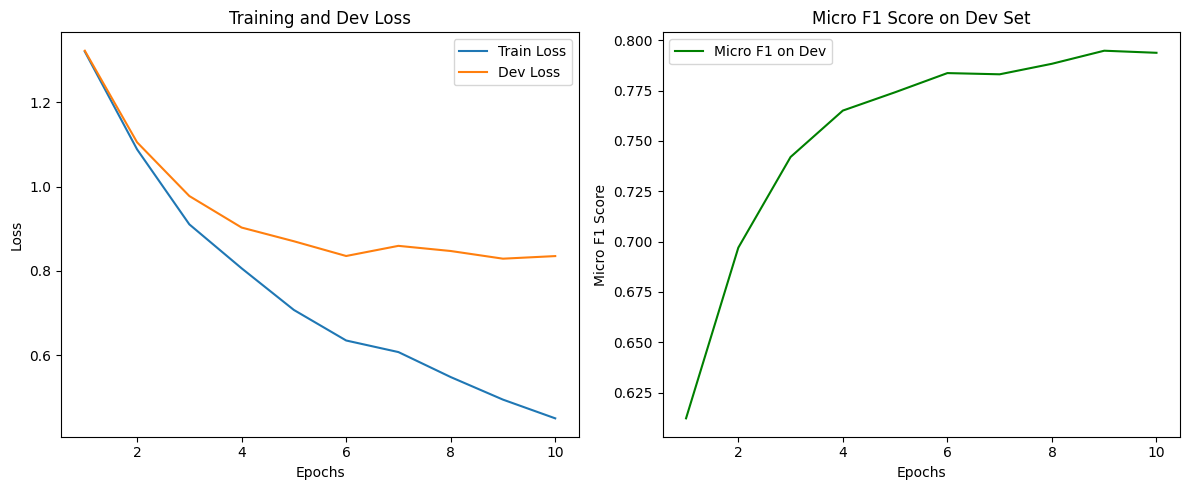

--------------------------------------
start test ...


<ipython-input-7-28f0425a73f3>:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(


test_loss: 0.835 | micro f1 on test:  0.7938


<ipython-input-7-28f0425a73f3>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_idx+i, id2rel[int(predict_label[i])]))


In [8]:
config = Config()
print('--------------------------------------')
print('some config:')
config.print_config()

print('--------------------------------------')
print('start to load data ...')
word2id, word_vec = WordEmbeddingLoader(config).load_embedding()
rel2id, id2rel, class_num = RelationLoader(config).get_relation()
loader = SemEvalDataLoader(rel2id, word2id, config)

train_loader, dev_loader = None, None
if config.mode == 1:  # train mode
    train_loader = loader.get_train()
    dev_loader = loader.get_dev()
test_loader = loader.get_test()
loader = [train_loader, dev_loader, test_loader]
print('finish!')

print('--------------------------------------')
# 将 Att_BLSTM 替换为 Att_LSTM
model = Att_LSTM(word_vec=word_vec, class_num=class_num, config=config)
model = model.to(config.device)
criterion = nn.CrossEntropyLoss()

if config.mode == 1:  # train mode
    train(model, criterion, loader, config)
predict_label = test(model, criterion, loader, config)
print_result(predict_label, id2rel)